# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning, InterpolationWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', InterpolationWarning)


# Function to help avoiding some memories issues

I came across the function below at Kaggle but you can find in many different places in the Internet (e.g., https://forum.numer.ai/t/reducing-memory/313). It helps overcoming some memory issues, especially when working with large datasets.


In [2]:
# Use it to decrease memory use

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# (S)ARIMA(X) Models

In the previous lesson we explored the basics of time series analysis. We looked at how to break a series down into its components (trend, seasonality, noise), and examined how to determine if a series is stationary—an essential concept in time series forecasting.

This notebook will dive into ARIMA models and their extensions, SARIMA and ARIMAX. Specifically, we'll cover:

- What an ARIMA model is and how it works  
- When to choose ARIMA, SARIMA, or ARIMAX  
- How to train these models  
- How to tune their parameters  
- How to generate future forecasts  
- How to assess the model's performance  

---

## ARIMA

The ARIMA model—short for **AutoRegressive Integrated Moving Average**—is a powerful forecasting tool that blends three key ideas:

- **AutoRegressive (AR)**: Uses past values of the time series to predict future values  
- **Integrated (I)**: Applies differencing to the series to make it stationary  
- **Moving Average (MA)**: Models the relationship between past forecast errors and future values  

An ARIMA model is generally specified as `ARIMA(p, d, q)`, where:

- **p**: Number of autoregressive (AR) terms  
- **d**: Number of times the data is differenced to achieve stationarity  
- **q**: Number of lagged forecast error terms (MA terms)  

Stationarity is a key assumption for ARIMA models—if your series isn't stationary, the model won't perform well. Thankfully, differencing (i.e., subtracting the previous value from the current one) can help achieve stationarity, and ARIMA can perform this automatically using the `d` parameter.

However, you should only difference as much as needed. Over-differencing can lead to poor results. To determine the optimal level of differencing (i.e., the value of `d`), you can use statistical tests such as:

- The [Augmented Dickey-Fuller (ADF) test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), which tests for a unit root (non-stationarity)  
- The [KPSS test](https://en.wikipedia.org/wiki/KPSS_test), which tests for trend stationarity  

Both tests were introduced in the earlier notebook and can help guide your preprocessing decisions before fitting an ARIMA model.


In [3]:
from statsmodels.tsa.stattools import adfuller, kpss

def evaluate_stationarity(series, max_diff):
    """
    Evaluate stationarity of a time series using ADF and KPSS tests after successive differencing steps.

    Args:
        series (pd.Series): Univariate time series data.
        max_diff (int): Maximum number of differencing steps to apply.

    Returns:
        pd.DataFrame: A DataFrame showing p-values and stationarity results from ADF and KPSS tests
                      after each level of differencing.
    """
    
    results = []

    for d in range(max_diff):
        adf_p = adfuller(series, autolag='AIC')[1]
        kpss_p = kpss(series, regression='c', nlags='auto')[1]
        
        is_adf_stationary = adf_p <= 0.05
        is_kpss_stationary = kpss_p > 0.05
        overall_stationary = is_adf_stationary and is_kpss_stationary
        
        results.append((d, adf_p, kpss_p, is_adf_stationary, is_kpss_stationary, overall_stationary))
        
        series = series.diff().dropna()
    
    return pd.DataFrame(results, columns=[
        'd', 'adf_p_value', 'kpss_p_value', 'adf_stationary', 
        'kpss_stationary', 'overall_stationary'
    ])


## ARIMAX

It is also possible to extend the ARIMA model to use e**x**ogenous inputs and create an ARIMAX model. In this model the time series is modeled using other independent variables as well as the time series itself. 

For example, when modeling the waiting time in an emergency room. The number of nurses available at a certain shift could be considered an external variable since it may impact on the waiting time. If this is indeed the case, by changing the number of nurses we can affect the waiting times. 

## SARIMA

If there is seasonality a `SARIMA (Seasonal ARIMA)` model should be used. When applying an ARIMA model, we are ignoring seasonality and using only part of the information in the data. As a consequence, we are not making the best predictions possible.

SARIMA models include extra parameters related to the seasonal part. Indeed, we can see a SARIMA model as two ARIMA models combined: one dealing with non-seasonal part and another dealing with the seasonal part.

Therefore, a SARIMA(p,d,q)(P,D,Q,S) model have all the parameters described above (non-seasonal parameters) and P,D,Q,S that are the seasonal parameters, i.e.,

* **Non-seasonal orders**

   - p: Autoregressive order
   - d: Differencing order
   - q: Moving average order

* **Seasonal orders**

    - P: Seasonal autoregressive order
    - D: Seasonal differencing order
    - Q: Seasonal moving average order
    - S: Length of the seasonal cycle
    
Now time to starting using what we have learn so far. 

# The Walmart Dataset

The data used from now on comes from [**Store Item Demand Forecasting Challenge**](https://www.kaggle.com/c/demand-forecasting-kernels-only) Kaggle competition.

The available [`data`](https://www.kaggle.com/c/demand-forecasting-kernels-only/data) consists of 5 years of store-item sales data split in a training dataset (train.csv) and a test dataset (test.csv). The objective of this competition was to forecast 3 months of sales for 50 different items at 10 different stores using the 5 years history of sales.

Our goal here is to use part of this data to apply what we have learnt about time series and the forecast methods introduced during this tutorial.

First of all, let's get to know our data.

In [4]:
df_train = pd.read_csv("../data/raw/store_item_demand_forecasting/train.csv")
reduce_mem_usage(df_train)
df_train.head()

Mem. usage decreased to 10.45 Mb (62.5% reduction)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df_train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int8  
 2   item    913000 non-null  int8  
 3   sales   913000 non-null  int16 
dtypes: int16(1), int8(2), object(1)
memory usage: 10.4+ MB


In [7]:
df_test = pd.read_csv("../data/raw/store_item_demand_forecasting/test.csv")
reduce_mem_usage(df_test)
df_test.head()

Mem. usage decreased to  0.60 Mb (56.2% reduction)


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [8]:
df_test.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int32 
 1   date    45000 non-null  object
 2   store   45000 non-null  int8  
 3   item    45000 non-null  int8  
dtypes: int32(1), int8(2), object(1)
memory usage: 615.4+ KB


The test dataset was provided by Kaggle to serve as a guide for the submission. It covers the 3 first months of 2018.

# EDA dataset : Getting to know our data

In [10]:
df_train.groupby('store').nunique()['item']

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [11]:
df_test.groupby('store').nunique()['item']

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

As we can see, both train and test datasets have 10 stores and each store offers 50 unique items.
`sales` is our target.

In [12]:
# Change dtype of date to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [13]:
print("Period covered in train dataset:", df_train['date'].min(),df_train['date'].max())
print("Period covered in test dataset:", df_test['date'].min(),df_test['date'].max())

Period covered in train dataset: 2013-01-01 00:00:00 2017-12-31 00:00:00
Period covered in test dataset: 2018-01-01 00:00:00 2018-03-31 00:00:00


The training dataset has data from January 1st, 2013 until December 31st, 2017. The goal is to predict sales of items in all stores from January 1st, 2018 until March 31st, 2018, i.e., 3 months.

Observe that the dataset consists of multiple time series, one for each store-item, i.e.,

In [14]:
# Check number of time series and lengths
print("Number of stores: {}.".format(len(df_train.groupby(["store"]).groups.keys())))
print("Number of items: {}.".format(len(df_train.groupby(["item"]).groups.keys())))
print("Number of time series: {}.".format(len(df_train.groupby(["store", "item"]).groups.keys())))

Number of stores: 10.
Number of items: 50.
Number of time series: 500.


Let's explore and get to know a bit more our dataset. Starting by checking how much each store sells.

In [15]:
df_train[['store','sales']].groupby('store').sum().sort_values('sales', ascending=False)

,sales
store,
2,6120128
8,5856169
3,5435144
10,5360158
9,5025976
4,5012639
1,4315603
5,3631016
6,3627670


<Axes: title={'center': 'Number of sales per store.'}, xlabel='store', ylabel='sales'>

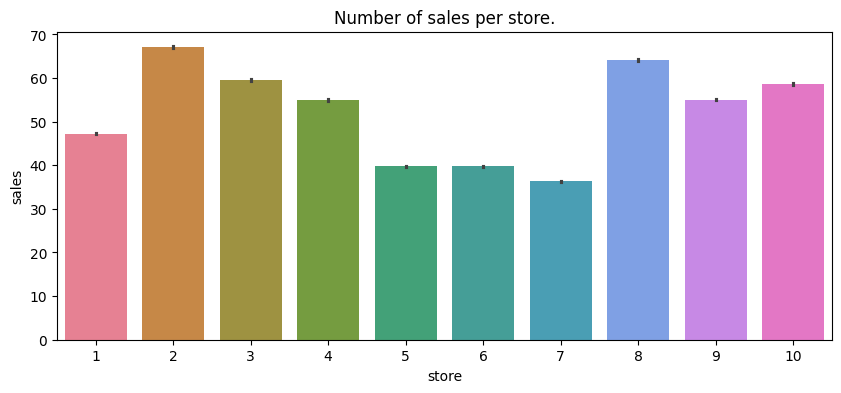

In [16]:
plt.figure(figsize=(10,4))
plt.title("Number of sales per store.")
sns.barplot(data=df_train,x='store',y='sales', palette="husl")

As we can see, store 2 has the highest volume of sales. Which products are the most sold there?

In [17]:
df_store_2 = df_train[df_train['store']==2]

reduce_mem_usage(df_store_2)

df_store_2.head()

Mem. usage decreased to  1.74 Mb (0.0% reduction)


,date,store,item,sales
1826,2013-01-01,2,1,12
1827,2013-01-02,2,1,16
1828,2013-01-03,2,1,16
1829,2013-01-04,2,1,20
1830,2013-01-05,2,1,16


In [18]:
df_store_2 = df_store_2[['date','item','sales']]

In [19]:
df_store_2[['item','sales']].groupby('item').sum().sort_values('sales', ascending=False)[:10]

,sales
item,
28,205677
15,205569
18,197422
13,197031
25,188856
45,188774
38,188533
22,188096
8,180939


The item with higher sales is item 28.

<Axes: title={'center': 'Number of sales per item in Store 2.'}, xlabel='item', ylabel='sales'>

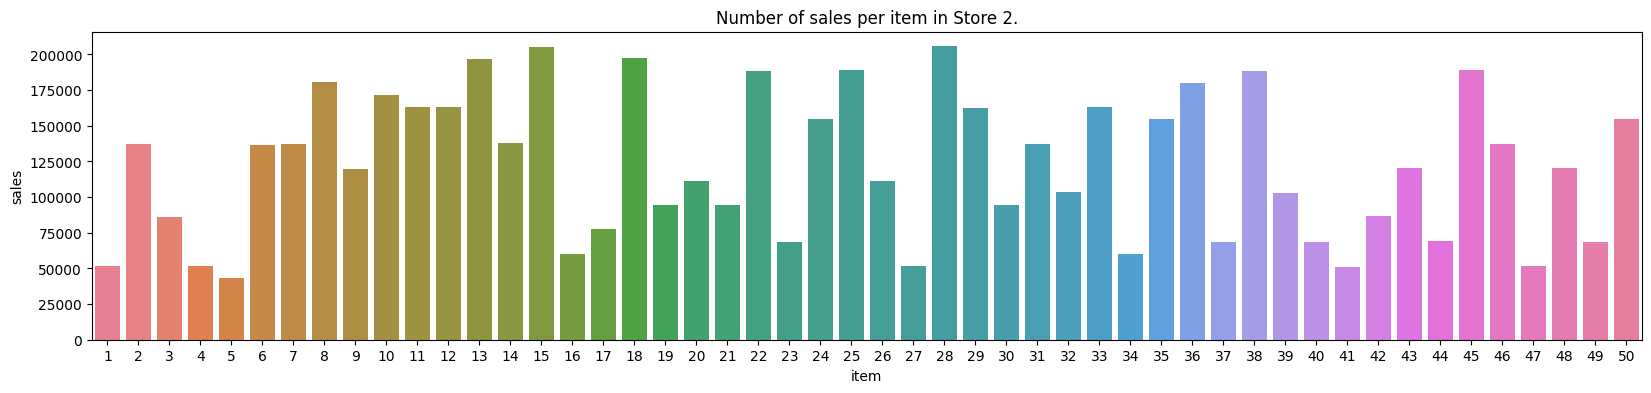

In [20]:
plt.figure(figsize=(20,4))
plt.title("Number of sales per item in Store 2.")
sns.barplot(data=df_store_2[['item','sales']].groupby('item').sum().reset_index(),x='item',y='sales', palette="husl")

In [21]:
# create some time related columns

df_store_2['year'] = df_store_2['date'].dt.year
df_store_2['month'] = df_store_2['date'].dt.month
df_store_2['day'] = df_store_2['date'].dt.dayofyear
df_store_2['weekday'] = df_store_2['date'].dt.weekday
df_store_2['year-month'] = df_store_2['date'].apply(lambda x: str(x.year)+'-'+str(x.month))

In [22]:
df_store_2.head()

,date,item,sales,year,month,day,weekday,year-month
1826,2013-01-01,1,12,2013,1,1,1,2013-1
1827,2013-01-02,1,16,2013,1,2,2,2013-1
1828,2013-01-03,1,16,2013,1,3,3,2013-1
1829,2013-01-04,1,20,2013,1,4,4,2013-1
1830,2013-01-05,1,16,2013,1,5,5,2013-1


<Axes: title={'center': 'Sales per week day.'}, xlabel='weekday', ylabel='sales'>

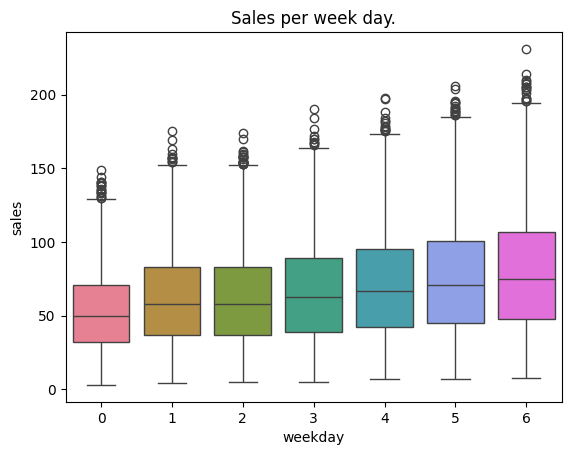

In [23]:
plt.title("Sales per week day.")
sns.boxplot(x="weekday", y="sales", data=df_store_2, palette="husl")


Higher sales occur during the weekend (5=Saturday, 6=Sunday). All days present some outliers.

<Axes: title={'center': 'Sales per month.'}, xlabel='month', ylabel='sales'>

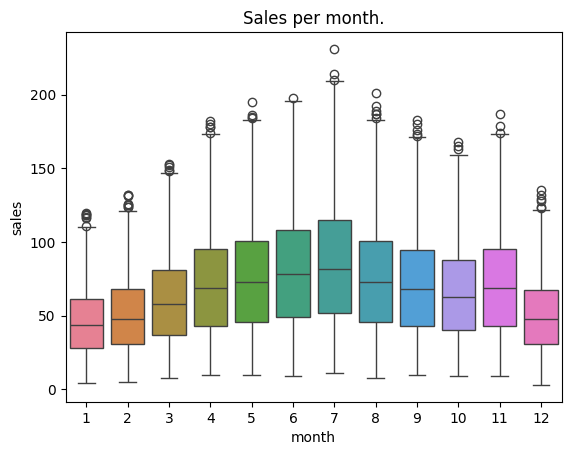

In [24]:
plt.title("Sales per month.")
sns.boxplot(x="month", y="sales", data=df_store_2, palette="husl")

Higher volume in sales is achieved in July and lowest in January.

<Axes: title={'center': 'Sales per Year-Month'}, xlabel='year-month', ylabel='sales'>

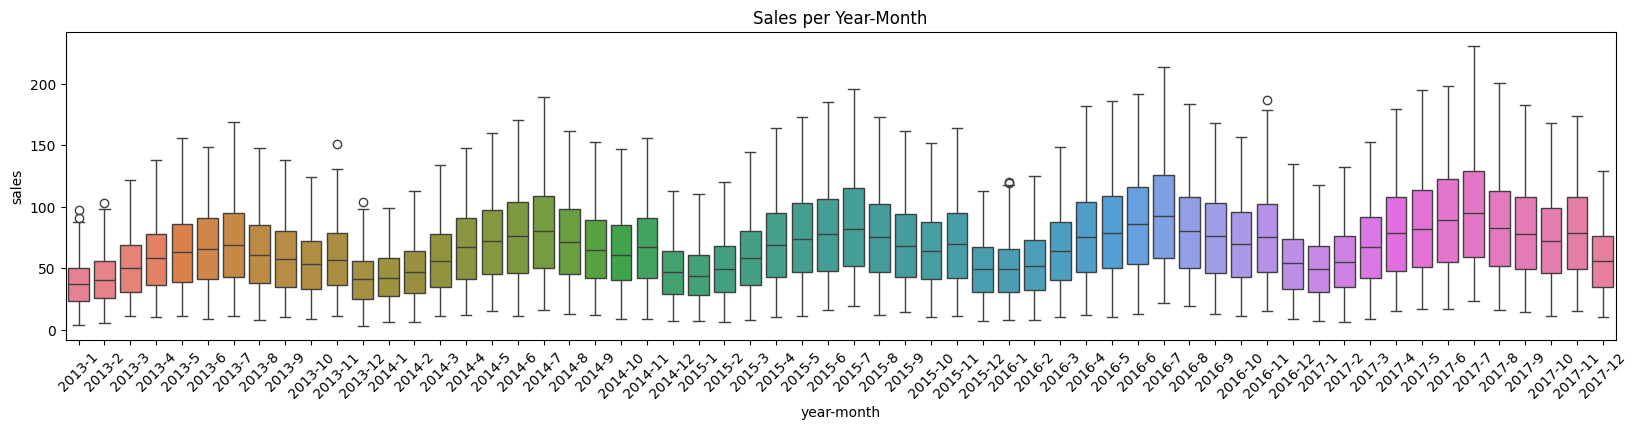

In [25]:
plt.figure(figsize=(20,4))
plt.xticks(rotation=45)
plt.title('Sales per Year-Month')
sns.boxplot(x="year-month", y="sales", data=df_store_2, palette="husl")


The pattern of sales per month seems to be pretty the same every year.

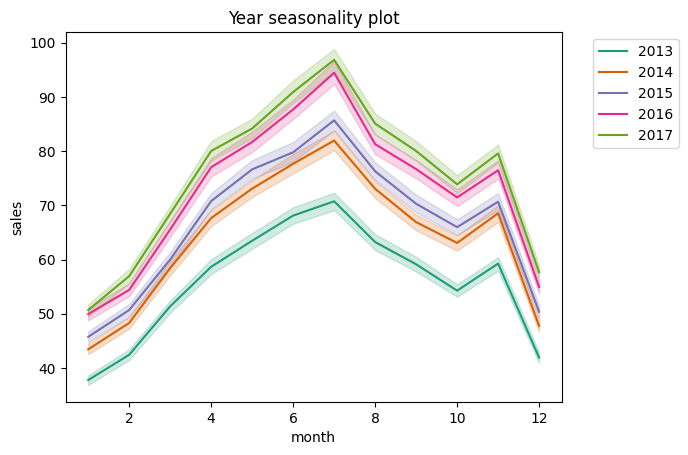

In [26]:
sns.lineplot(data=df_store_2, 
             x='month', 
             y='sales', 
             hue='year', 
             legend='full',
            palette='Dark2')

# add title
plt.title('Year seasonality plot')

# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

The behavior of sales is pretty much the same every year with higher number of sales in July. Furthermore, it show us that the volume of sales is increasing every year. Interesting, to notice that year 2014 and 2015 seem to be close to each other in the number of sales. The same is observed with 2016 and 2017.

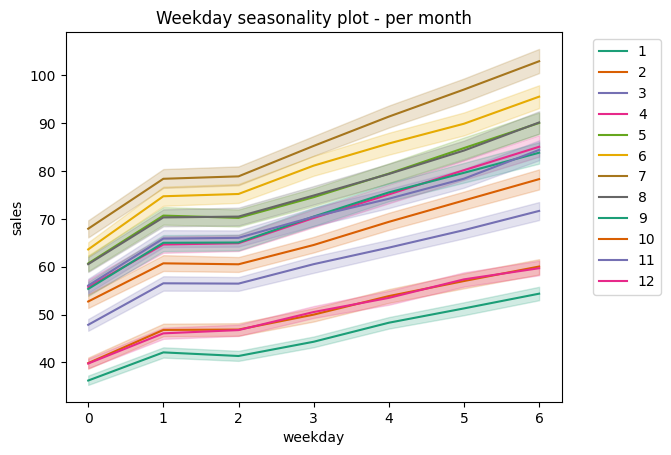

In [27]:
sns.lineplot(data=df_store_2, 
             x='weekday', 
             y='sales', 
             hue='month', 
             legend='full',
            palette='Dark2')

# add title
plt.title('Weekday seasonality plot - per month')

# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

This plot confirms the higher value of sales during the weekends and also July as the month with more sales.

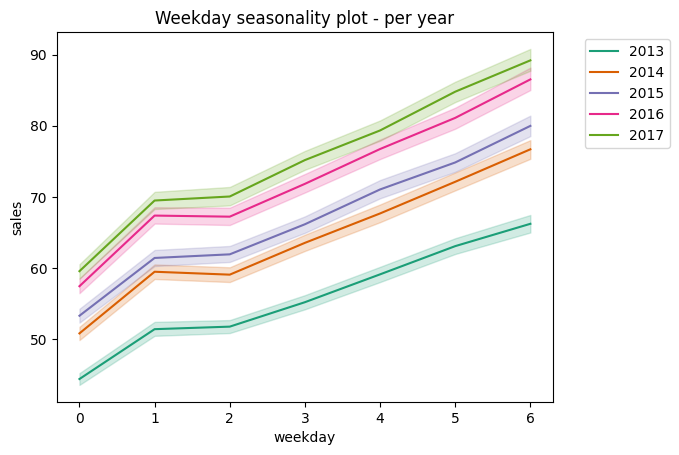

In [28]:
sns.lineplot(data=df_store_2, 
             x='weekday', 
             y='sales', 
             hue='year', 
             legend='full',
            palette='Dark2')

# add title
plt.title('Weekday seasonality plot - per year')

# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Here we also verify higher number of sales during the weekend. In addition, we confirm what was observed on the year seasonality plot: Increase in sales every year with years 2014 and 2015 close in number of sales as well as year 2016 and 2017.

# Box-Jenkins Method

To learn applying (S)ARIMA(X) models we will follow some steps based on [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method). This popular framework provides a systematic way that involves getting to know your data and applying the appropriate methods to choose parameters that will lead to a good model.

![](../images/Box-Jenkins-Method.PNG)



Visualize times series sales of item 28 at store 2

As we saw previously in this data, we have 500 time series which are defined by the pair store-item. Here we are working with forecasting individual time series. To forecast sales for all stores and all items we need to apply a forecast model to each one of the time series. 

With purpose of demonstration, in this tutorial we will work with only one time series: sales of item 28 (the most sold item) at store 2 (the store with the highest number of sales).

## STEP 1 - Identify

Following the schema above in this step we use tools to identify characteristics of the time series so we can build an appropriate model. 

Here we search for answers for questions such as:

* _Is the time series stationary?_
    
* _If not stationary, which transformation should we apply to make it stationary?_
   
* _Is the time series seasonal?_

* _If seasonal what is the seasonal period?_

* _Which orders to use? (p for AR, q for MA)_

### Visualize times series sales of item 28 at store 2

As we saw previously in this data, we have 500 time series which are defined by the pair `store-item`. Here we are working with forecasting individual time series. To forecast sales for all stores and all items we need to apply a forecast model to each one of the time series. 

With purpose of demonstration, in this tutorial we will work with only one time series: sales of item 28 (the most sold item) at store 2 (the store with the highest number of sales).


In [29]:
df_store_2_item_28 = df_store_2[['date','sales']][df_store_2['item']==1].reset_index(drop=True)
df_store_2_item_28.head()

,date,sales
0,2013-01-01,12
1,2013-01-02,16
2,2013-01-03,16
3,2013-01-04,20
4,2013-01-05,16


In [30]:
df_store_2_item_28.tail()

,date,sales
1821,2017-12-27,19
1822,2017-12-28,21
1823,2017-12-29,18
1824,2017-12-30,24
1825,2017-12-31,31


In [31]:
# save data in csv

df_store_2_item_28.to_csv("../data/processed/sales_store_2_item_28.csv", index=False)

In [32]:
# set date as index 
df_store_2_item_28_time = df_store_2_item_28.set_index('date')

In [33]:
df_store_2_item_28_time

,sales
date,
2013-01-01,12
2013-01-02,16
2013-01-03,16
2013-01-04,20
2013-01-05,16
...,...
2017-12-27,19
2017-12-28,21
2017-12-29,18


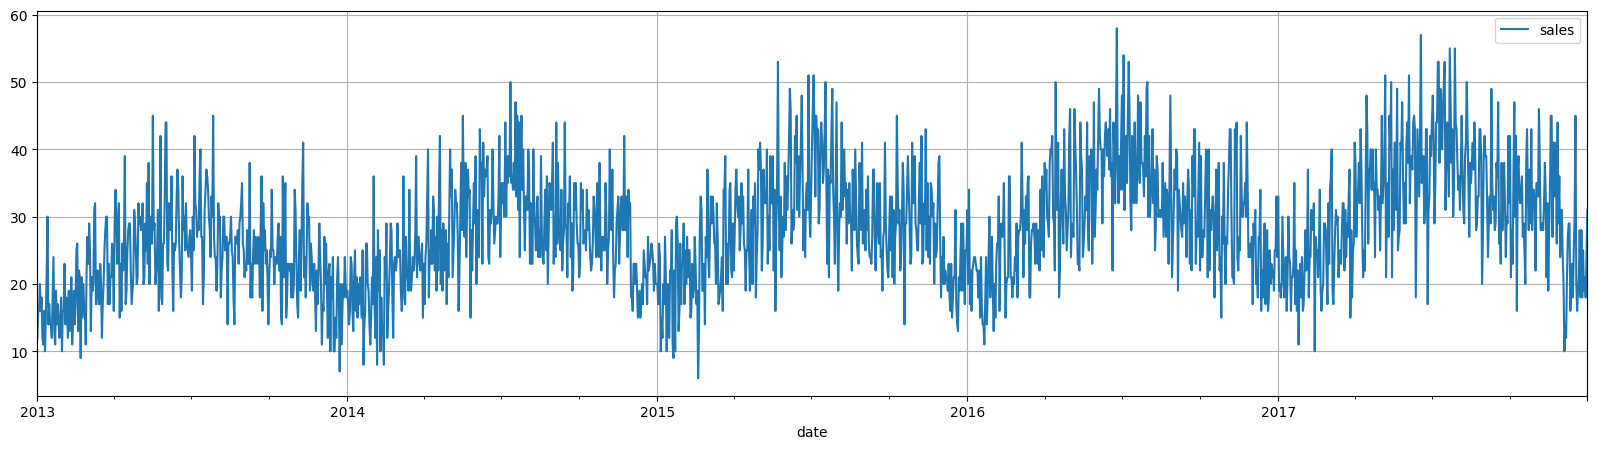

In [34]:
# Plot the entire time series diet and show gridlines
df_store_2_item_28_time.plot(grid=True,figsize=(20,5))
plt.show()

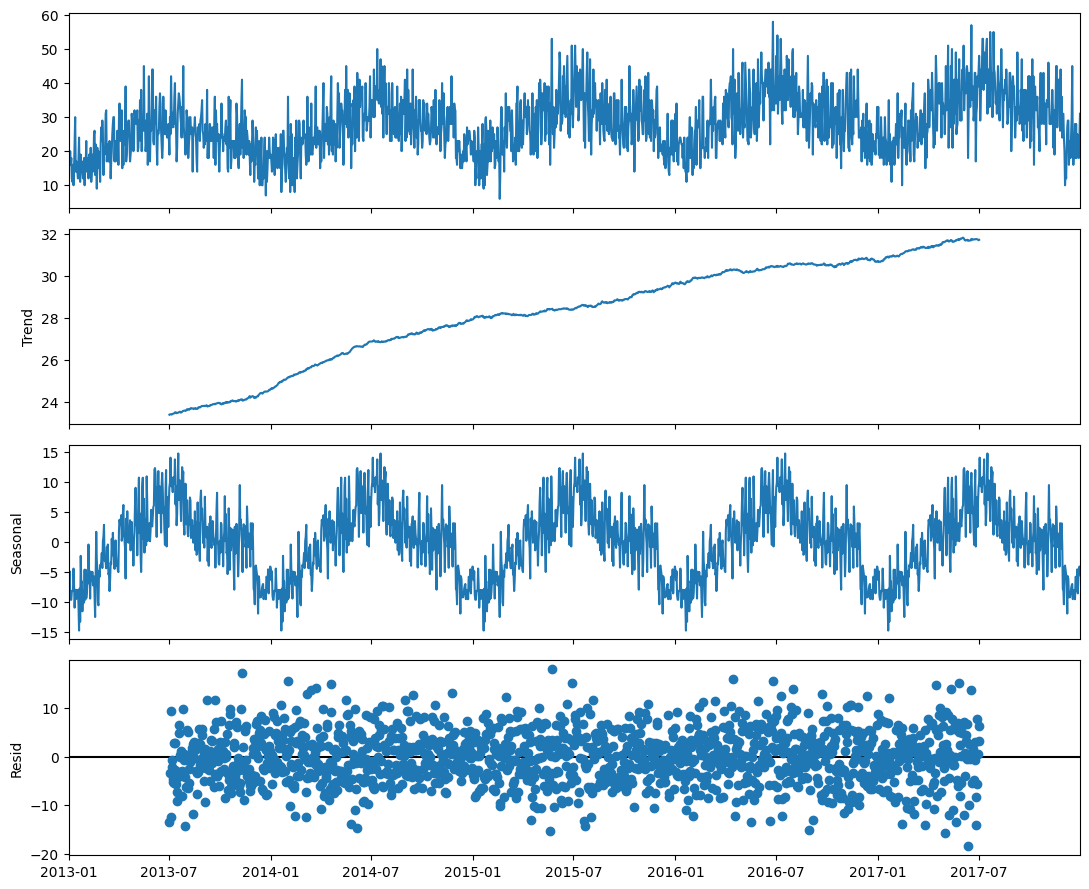

In [35]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df_store_2_item_28_time, 
                                          model = 'additive',
                                          period=365, # cycle repeats 365 days, i.e., every year
                                         ) 
fig = decomposition.plot()
plt.show()

From the decomposition above we can conclude:

1. There is a `upward trend` on sales. Therefore, this time series is `not stationary`.
2. From the seasonal component we can observe that the model is `additive`, since the seasonal component is similar (not getting multiplied) over the period of time.
3. Also we can observe on the seasonal component `seasonality` in sales with lower sales in January and higher sales in July.

Since our data is not stationary, we need to answer `What differencing will make it stationary? `. For this we will use our `obtain_adf_kpss_results` function to find out how many times we need to apply differencing in order to make this time series stationary. This will be our parameter `d` for the ARIMA model.

### Apply Stationarity Tests

In [36]:
obtain_adf_kpss_results(df_store_2_item_28_time,3)

NameError: name 'obtain_adf_kpss_results' is not defined

`d=1`, applying differencing only once is enough to make our time series is stationary.

### Plot ACF and PACF

Autocorrelation and partial autocorrelation plots are essential tools in time series analysis and model selection. These plots can provide valuable insight into the structure of the data and guide the selection of ARIMA parameters. They can also help determine whether differencing is needed—or if it's been overapplied.

The **Autocorrelation Function (ACF)** plot displays the correlation of the time series with its own past values (lags). This is sometimes referred to as a correlogram. The ACF shows both direct and indirect correlations between observations and their lags. The plot includes a 95% confidence interval (shaded in blue); if the bars fall within this region, the correlations are not considered statistically significant.

In contrast, the **Partial Autocorrelation Function (PACF)** plot focuses only on the *direct* correlation between an observation and its lag, removing the influence of any intermediate lags. In other words, PACF shows the correlation of the residuals after accounting for prior lags.

So how can these plots help us choose the **p** (autoregressive) and **q** (moving average) parameters in an ARIMA model?

A helpful intuition on how to use ACF and PACF for ARIMA modeling is provided in [this article](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/), and you can find a more in-depth explanation [here](https://people.duke.edu/~rnau/411arim3.htm).

Additionally, ACF and PACF can give clues about whether differencing is required. For instance:

- If ACF values are high and decay slowly, it's a sign of non-stationarity—suggesting that differencing may be needed.
- If the autocorrelation at lag 1 is strongly negative after differencing, it may indicate that the data has been differenced one time too many.

Since we suspect our time series is non-stationary, let’s visualize the ACF and PACF plots for both the original and differenced series to better understand its characteristics.


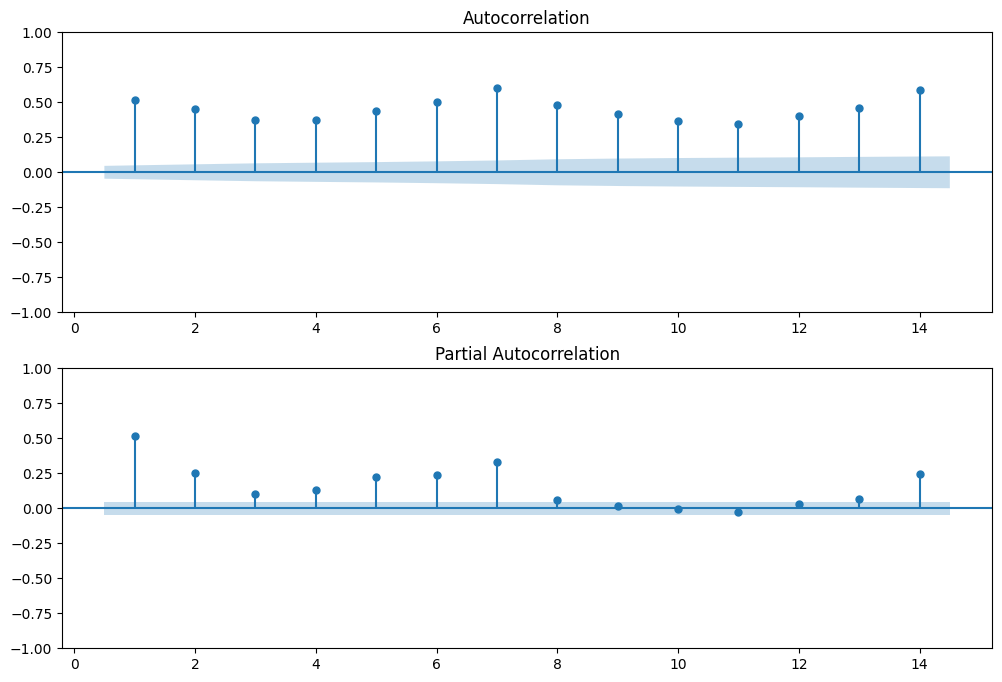

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(df_store_2_item_28_time,lags=14, zero=False, ax=ax1)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(df_store_2_item_28_time,lags=14, zero=False, ax=ax2)

plt.show()

The ACF above shows a periodic correlation pattern. To find the period we look for a lag greater than one, which is a peak in the ACF plot. Here, there is a peak at 7 lags, i.e., the seasonal component repeats every 7 steps (a week). 

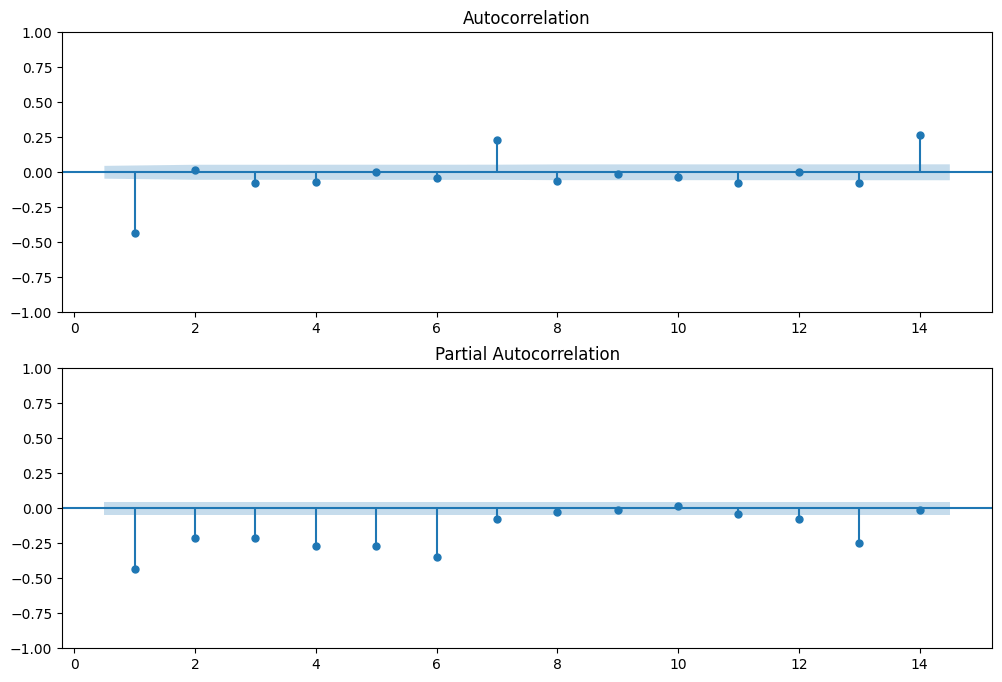

In [38]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(df_store_2_item_28_time.diff().dropna(),lags=14, zero=False, ax=ax1)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(df_store_2_item_28_time.diff().dropna(),lags=14, zero=False, ax=ax2)

plt.show()

By observing the ACF and PACF plots after making the time series stationary, we cannot see clear any trails off in neither of the plots.

We can also infer from those plots that there is a seasonal behavior of period 7 which is clear by the picks at lag 7, 14, 21 etc. (every week). This shows us the need of a seasonal term in our ARIMA model. In other words, we need a SARIMA model.

## STEP 2: Estimate Coefficients (p,q)

Although we had clear signs that we need a SARIMA model, we will start by applying a ARIMA model instead. By doing so we can obtain a better understanding on the differences between ARIMA and SARIMA in what concern the use of Box-Jenkins’s method. In addition, it will be clear the advantages of choosing the appropriate model.

ACF and PACF plots can help us find appropriate values for parameters `p` and `q` . However, the interpretation of these plots is not always clear. To obtain more assurance to our choices we can apply an empirical method. This method consists on fitting the ARIMA model for different values of p and q, and choosing the best value based on metrics such as AIC and BIC.

`AIC (Akaike information criterion)` is a metric which tells us how good a model is. Lower the value, better the model. The AIC also penalizes models which have lots of parameters. This means if we set the order too high compared to the data, we will get a high AIC value. This stops us overfitting to the training data. 

`BIC (Bayesian information criterion)` is similar to AIC, therefore lower value means a better model. However, BIC penalizes additional model orders more than AIC. As consequence, BIC will sometimes suggest a simpler model. 

After fitting a model, we can access its summary statistics, and there is where we can find the values of AIC and BIC.

Usually there is agreement between AIC and BIC. If there is no agreement choose smaller AIC if you prefer a predictive model. Otherwise, choose smaller BIC for an explanatory model.

Check the how to obtain the summary statistics in the following example:

In [39]:
df_store_2_item_28_time.index = pd.DatetimeIndex(df_store_2_item_28_time.index.values,
                               freq=df_store_2_item_28_time.index.inferred_freq)

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# just an example
model = SARIMAX(df_store_2_item_28_time, order=(1,1,1), freq='D')
results = model.fit()
# statistics of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6039.816
Date:                Wed, 09 Apr 2025   AIC                          12085.632
Time:                        16:44:45   BIC                          12102.160
Sample:                    01-01-2013   HQIC                         12091.729
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1127      0.026      4.321      0.000       0.062       0.164
ma.L1         -0.9163      0.011    -84.013      0.000      -0.938      -0.895
sigma2        43.8235      1.478     29.654      0.000      40.927      46.720
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.67
Prob(Q):                              0.95   Prob(JB):                         0.01
Heteroskedasticity (H):               1.39   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now let's scan different values of p and q and choose the values that points to smaller AIC and/or BIC.

In [41]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-6
for p in range(7):
  # Loop over q values from 0-6
    for q in range(7):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(df_store_2_item_28_time, order=(p,1,q), freq="D") #because adf test showed that d=1
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

In [42]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC')

,p,q,AIC,BIC
40,5,5,11661.016327,11721.619015
33,4,5,11662.203942,11717.297294
34,4,6,11683.895439,11744.498127
48,6,6,11708.768008,11780.389367
26,3,5,11718.842648,11768.426666
41,5,6,11719.411001,11785.523024
47,6,5,11726.178191,11792.290214
25,3,4,11726.938275,11771.012957
24,3,3,11728.916696,11767.482043
18,2,4,11729.776699,11768.342046


In [43]:
# Print order_df in order of increasing BIC
order_df.sort_values('BIC')

,p,q,AIC,BIC
33,4,5,11662.203942,11717.297294
40,5,5,11661.016327,11721.619015
34,4,6,11683.895439,11744.498127
24,3,3,11728.916696,11767.482043
18,2,4,11729.776699,11768.342046
26,3,5,11718.842648,11768.426666
25,3,4,11726.938275,11771.012957
48,6,6,11708.768008,11780.389367
19,2,5,11736.784934,11780.859616
20,2,6,11733.404604,11782.988621


Both AIC and BIC agree that the best model in this case should be ARIMA(4,1,5).

## STEP 3: Model Evaluation

Before, using a model we want to know how accurate it is. Here we present some tools to evaluate the model before considering it the best one and putting it to production.

For this evaluation we focus on the residuals. The residuals are the difference between the model's one-step-ahead predictions and the real values of the time series. 

### Mean Absolute Error (MAE)

We start by calculating the `Mean Absolute Error (MAE)` of the residuals. This will show us how far, on average, the predictions are from the true values.

In [44]:
arima_model = SARIMAX(df_store_2_item_28_time, order=(4,1,5))
# fit model
arima_results = arima_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 4.727


In [45]:
df_store_2_item_28_time.describe()

,sales
count,1826.000000
mean,28.173604
std,8.681013
min,6.000000
25%,22.000000
50%,28.000000
75%,34.000000
max,58.000000


The mean average error is about 5 sales per day where the average sale of item 28 in store 2 is in average 28 sales per day. Can we do better than this?

For an ideal model, the residuals should be uncorrelated white Gaussian noise centered on zero. Therefore, continuing our model evaluation we use tools that allow us to check if it is true.

### Diagnostic Summary Statistics

Another important tool to evaluate the model is the analysis of the residual test statistics in the results summary.

Now we evaluate Prob(Q) and Prob(JB) applying, respectively, the following tests:

[`Ljung–Box test`](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test):

**Null hypothesis**: There are no correlations in the residuals.

[`Jarque–Bera test`](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test)

**Null hypothesis**: Residuals are normally distributed.

In [46]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -5821.102
Date:                Wed, 09 Apr 2025   AIC                          11662.204
Time:                        16:45:12   BIC                          11717.297
Sample:                    01-01-2013   HQIC                         11682.527
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5077      0.022    -23.156      0.000      -0.551      -0.465
ar.L2          0.2374      0.012     19.253      0.000       0.213       0.262
ar.L3         -0.5673      0.012    -47.901      0.000      -0.591      -0.544
ar.L4         -0.9490      0.021    -44.386      0.000      -0.991      -0.907
ma.L1         -0.4131      0.034    -12.024      0.000      -0.480      -0.346
ma.L2         -0.6482      0.044    -14.615      0.000      -0.735      -0.561
ma.L3          0.7652      0.032     23.712      0.000       0.702       0.828
ma.L4          0.3933      0.044      8.992      0.000       0.308       0.479
ma.L5         -0.7916      0.031    -25.243      0.000      -0.853      -0.730
sigma2        33.3244      1.132     29.428      0.000      31.105      35.544
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 8.48
Prob(Q):                              0.45   Prob(JB):                         0.01
Heteroskedasticity (H):               1.33   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Prob(Q) = 0.88 > 0.05.  We shouldn't reject the null hypothesis that the residuals are uncorrelated so the `residuals are not correlated`. 

Prob(JB) = 0.02 < 0.05. We reject the null hypothesis that the residuals are normally distributed. Therefore, the residuals are `not normally distributed`.

### Plot Diagnostics

In addition, there are 4 common plots to help us deciding whether a model is a good fit for the data in question.

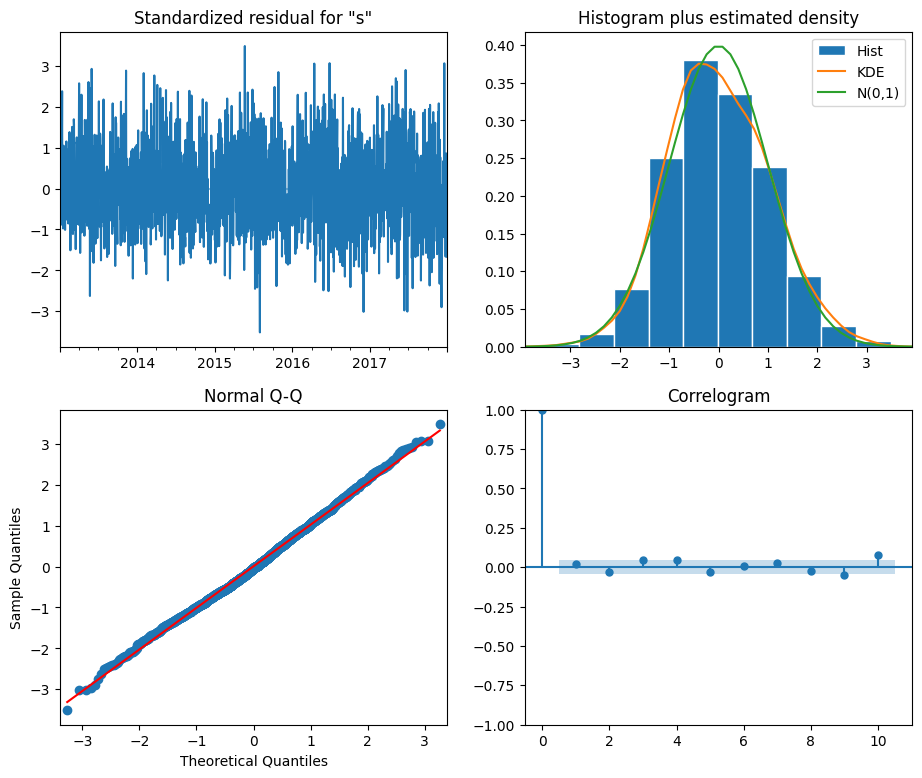

In [47]:
# Create the 4 diagostics plots using plot_diagnostics method
arima_results.plot_diagnostics()
plt.show()

For an ideal model the residuals should be uncorrelated white Gaussian noise centered on zero. By analyzing the plots above having this in mind we can evaluate if we have a good model or not.

So, let's analyze those plots (Clockwise from left-top plot):

* **Standardized residual**: There are no obvious patterns in the residuals. This points out to a good model

* **Histogram plus kde estimate**: The histogram shows the measured distribution of the residuals while the green line shows the KDE curve (smoothed version of the histogram). The green line shows a normal distribution. For a good model the orange line should be similar to the green line. The orange curve is not very similar to the green one.

* **Correlogram** or ACF plot: 95% of correlations for lag greater than one should not be significant (inside the blue area). This is also the case, i.e., good model.

* **Normal Q-Q:** Most of the data points should lie on the straight line, indicating a normal distribution of the residuals. This happens here.

Therefore, all in all the model pointed by our empirical search seems to be a good model.

**Final tips:**

If the residuals are not normally distributed try to increase `d`.

If the residuals are correlated try to increase `p` or `q`.


# SARIMA Model

Now that we've explored ARIMA, it's time to address seasonality by introducing SARIMA, which includes seasonal components in the model. To do this, we must select additional seasonal parameters: **P**, **D**, **Q**, and **S**.

## Using ACF to Identify Seasonal Cycles

From earlier analysis, the ACF plot gave us a strong indication that the series follows a weekly seasonal pattern—suggesting a seasonal period of `S = 7`.

This is a great use of ACF plots: when the seasonal cycle isn't immediately obvious from the raw time series, periodic spikes in the ACF plot can reveal it.

**Note:** Always ensure your time series is stationary before interpreting ACF and PACF plots.

## Seasonal Differencing

To make a time series stationary, we often use differencing—this is how we determine the `d` parameter in ARIMA, typically confirmed with the ADF test.

For seasonal patterns, we may also need to apply *seasonal differencing*. Unlike regular differencing (which subtracts the previous value), seasonal differencing subtracts the value from the same point in the previous season or cycle. For example, with weekly seasonality, each point would be subtracted by the value from 7 time steps ago.

So:
- Use **regular differencing** for trends (`d`)
- Use **seasonal differencing** for repeated seasonal patterns (`D`)

In cases where seasonality is strong, we generally set `D = 1`. A good rule of thumb is to keep `d + D ≤ 2` to avoid over-differencing.

Once the series has been made stationary using the appropriate levels of differencing (`d` and `D`), the next step is to identify the other model parameters:

- Use ACF and PACF plots of the **differenced** series to determine non-seasonal terms: `p` and `q`
- To find seasonal terms `P` and `Q`, use ACF and PACF plots at **seasonal lags** (multiples of `S`, e.g., 7, 14, 21...)

This approach allows us to capture both short-term and seasonal dependencies in the SARIMA model.


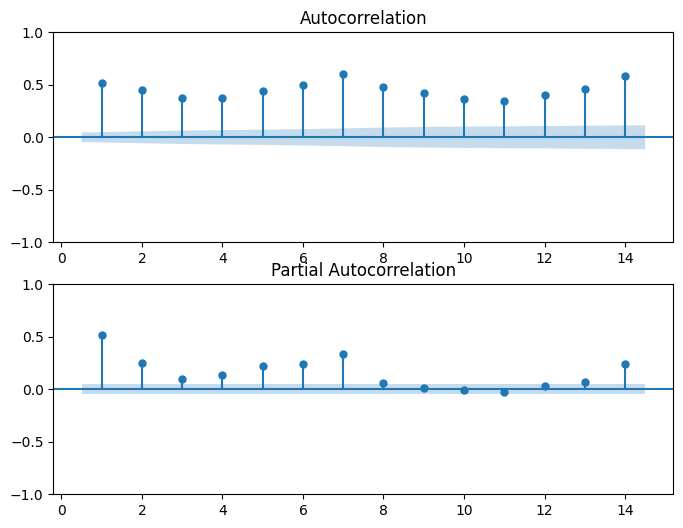

In [48]:
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(df_store_2_item_28_time, lags=14, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(df_store_2_item_28_time, lags=14, zero=False, ax=ax2)

plt.show()

In [49]:
# Take the first and seasonal differences (S=7) and drop NaNs
df_store_2_item_28_time_diff = df_store_2_item_28_time.diff().diff(7).dropna()

For the seasonal part, we do like previously:

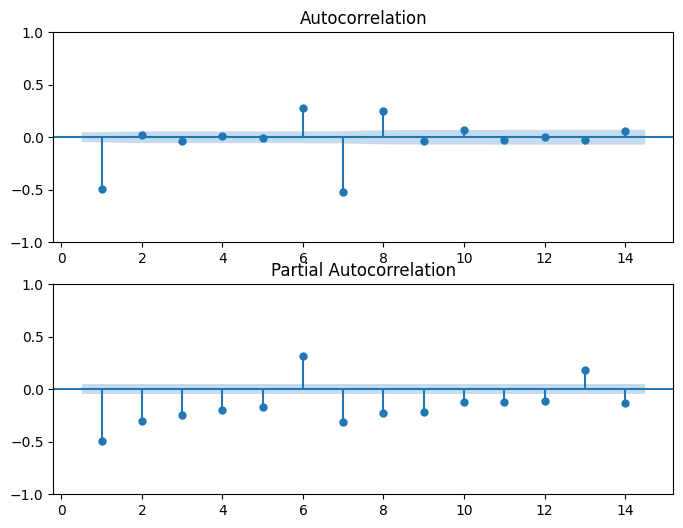

In [50]:
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(df_store_2_item_28_time_diff, lags=14, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(df_store_2_item_28_time_diff, lags=14, zero=False, ax=ax2)

plt.show()

The non-seasonal ACF and PACF plots above show MA model pattern with `q=1`.

For the seasonal part we set the lags parameter to a list of lags instead of a maximum, and then plot ACF and PACF for these specific lags only. 

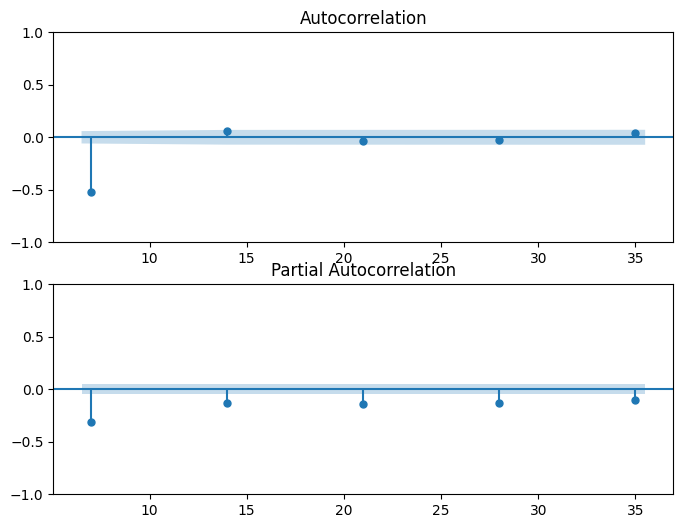

In [51]:
# Make list of lags
lags = [7, 14, 21, 28, 35]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(df_store_2_item_28_time_diff, lags=lags, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(df_store_2_item_28_time_diff, lags=lags, zero=False, ax=ax2)

plt.show()

The Seasonal ACF and PACF plots look like an MA(1) model, i.e., Q=1. We could select the model that combines both of these, i.e., SARIMA$(0,1,6)(0,1,1)_7$

In [52]:
sarima_01_model = SARIMAX(df_store_2_item_28_time, order=(0,1,6), seasonal_order=(0,1,1,7))
sarima_01_results = sarima_01_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_01_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)


MAE: 4.555


In [53]:
sarima_01_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1826
Model:             SARIMAX(0, 1, 6)x(0, 1, [1], 7)   Log Likelihood               -5734.902
Date:                             Wed, 09 Apr 2025   AIC                          11485.804
Time:                                     16:45:21   BIC                          11529.848
Sample:                                 01-01-2013   HQIC                         11502.054
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8688      0.023    -37.673      0.000      -0.914      -0.824
ma.L2          0.0019      0.032      0.060      0.952      -0.061       0.065
ma.L3         -0.0070      0.033     -0.216      0.829      -0.071       0.057
ma.L4          0.0082      0.030      0.270      0.787      -0.051       0.068
ma.L5         -0.0022      0.030     -0.072      0.942      -0.062       0.057
ma.L6         -0.0064      0.024     -0.268      0.789      -0.054       0.041
ma.S.L7       -0.9915      0.007   -150.225      0.000      -1.004      -0.979
sigma2        31.6282      1.096     28.847      0.000      29.479      33.777
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.15
Prob(Q):                              0.97   Prob(JB):                         0.13
Heteroskedasticity (H):               1.31   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Another way to determine model parameters is the empiric method considering values of AIC and BIC. However, now we have much more parameters to consider. In this case, the use of `Automated Model Selection` might be very handy. 

Prob(Q) = 0.97 > 0.05.  We shouldn't reject the null hypothesis that the residuals are uncorrelated so the `residuals are not correlated`. 

Prob(JB) = 0.13 > 0.05. We shouldn't reject the null hypothesis that the residuals are normally distributed. Therefore, the residuals are `normally distributed`.

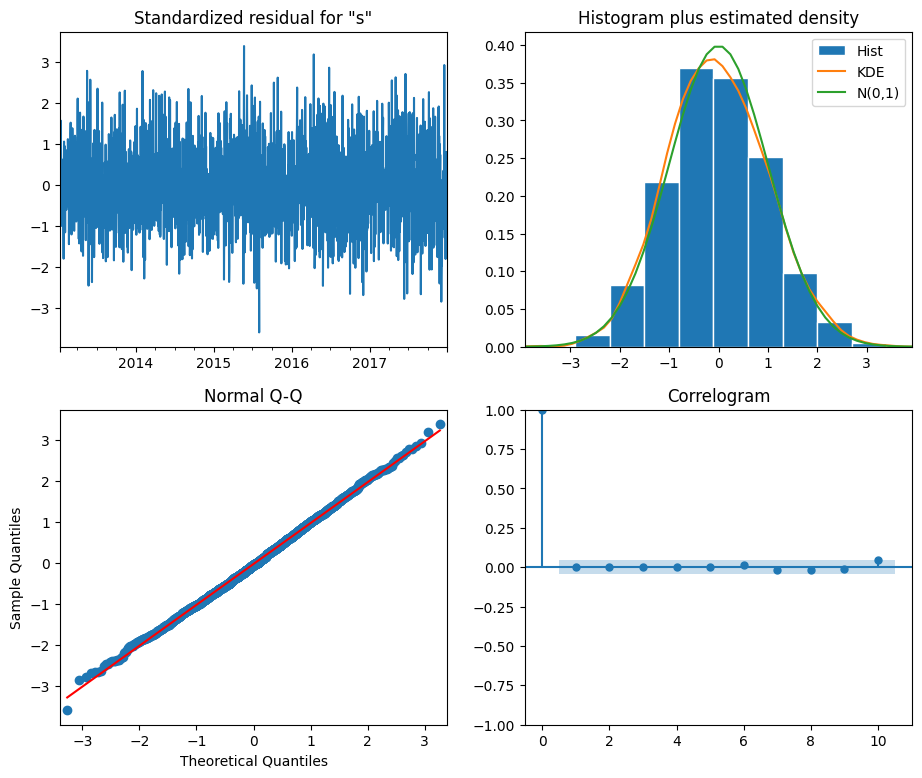

In [54]:
sarima_01_results.plot_diagnostics()
plt.show()

* **Standardized residual**: Shows no obvious patterns in the residuals. This is the case which points out to a good model

* **Histogram plus kde estimate**: The orange curve is similar to the green one.

* **Correlogram** or ACF plot: 95% of correlations for lag greater than one should not be significant (inside the blue area). This is also the case, i.e., good model

* **Normal Q-Q:** Most of the data points should lie on the straight line, with excepting of the points at the extremes. This indicates a normal distribution of the residuals.

## Automated Model Selection

The [`pmdarima`](http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) library offers a convenient way to automatically determine the optimal order of ARIMA or SARIMA models using the `auto_arima` function.

This function leverages insights from the Box-Jenkins methodology, allowing you to predefine some parameters based on your earlier analysis (e.g., seasonality, differencing, etc.). While automation can significantly reduce the time spent tuning models, it's important to approach it with caution.

Automated model selection isn't foolproof—especially when the input data is noisy or non-ideal. Misleading test scores can occasionally steer the algorithm toward suboptimal choices.

Although `data` is the only required input for `auto_arima`, incorporating your own domain knowledge—for instance, specifying the seasonal period (`m`), maximum orders, or differencing levels (`d`, `D`)—can help guide the algorithm and improve the quality of the selected model.


In [55]:
df_store_2_item_28_time.head()

,sales
2013-01-01,12
2013-01-02,16
2013-01-03,16
2013-01-04,20
2013-01-05,16


In [57]:
import pmdarima as pm

# Create auto_arima model
# model1 = pm.auto_arima(df_store_2_item_28_time, #time series
#                       seasonal=True, # is the time series seasonal
#                       m=7, # the seasonal period - one week?
#                       d=1, # non-seasonal difference order
#                       D=1, # seasonal difference order
#                  	  max_p=6, # max value of p to test 
#                       max_q=6, # max value of p to test
#                       max_P=6, # max value of P to test 
#                       max_Q=6, # max value of Q to test 
#                       information_criterion='aic', # used to select best mode
#                       trace=True, # prints the information_criterion for each model it fits
#                       error_action='ignore', # ignore orders that don't work
#                       stepwise=True, # apply an intelligent order search
#                       suppress_warnings=True) 

# # Print model summary
# print(model1.summary())

Automated model selection choses SARIMA$(6,1,1)(6,1,0)_7$ as best model based on AIC.

In [58]:
sarima_02_model = SARIMAX(df_store_2_item_28_time, order=(6,1,1), seasonal_order=(6,1,0,7))
sarima_02_results = sarima_02_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_02_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 4.788


This value is a bit higher than the one obtained by previous model.

In [59]:
sarima_02_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 1)x(6, 1, [], 7)   Log Likelihood               -5826.363
Date:                            Wed, 09 Apr 2025   AIC                          11680.726
Time:                                    16:47:24   BIC                          11757.803
Sample:                                01-01-2013   HQIC                         11709.164
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0671      0.026      2.594      0.009       0.016       0.118
ar.L2          0.0575      0.027      2.117      0.034       0.004       0.111
ar.L3          0.0467      0.026      1.799      0.072      -0.004       0.098
ar.L4          0.0486      0.026      1.905      0.057      -0.001       0.099
ar.L5          0.0363      0.026      1.390      0.165      -0.015       0.087
ar.L6          0.0410      0.025      1.613      0.107      -0.009       0.091
ma.L1         -0.9463      0.014    -69.672      0.000      -0.973      -0.920
ar.S.L7       -0.8558      0.024    -36.375      0.000      -0.902      -0.810
ar.S.L14      -0.6815      0.032    -21.632      0.000      -0.743      -0.620
ar.S.L21      -0.5757      0.035    -16.430      0.000      -0.644      -0.507
ar.S.L28      -0.4127      0.033    -12.482      0.000      -0.478      -0.348
ar.S.L35      -0.2412      0.031     -7.798      0.000      -0.302      -0.181
ar.S.L42      -0.1133      0.024     -4.677      0.000      -0.161      -0.066
sigma2        35.3660      1.202     29.416      0.000      33.010      37.722
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.04
Prob(Q):                              1.00   Prob(JB):                         0.98
Heteroskedasticity (H):               1.31   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Prob(Q) 1.00 > 0.05.  We shouldn't reject the null hypothesis that the residuals are uncorrelated so the `residuals are not correlated`. 

Prob(JB) 0.98 > 0.05. We shouldn't reject the null hypothesis that the residuals are normally distributed. Therefore, the residuals are `normally distributed`.

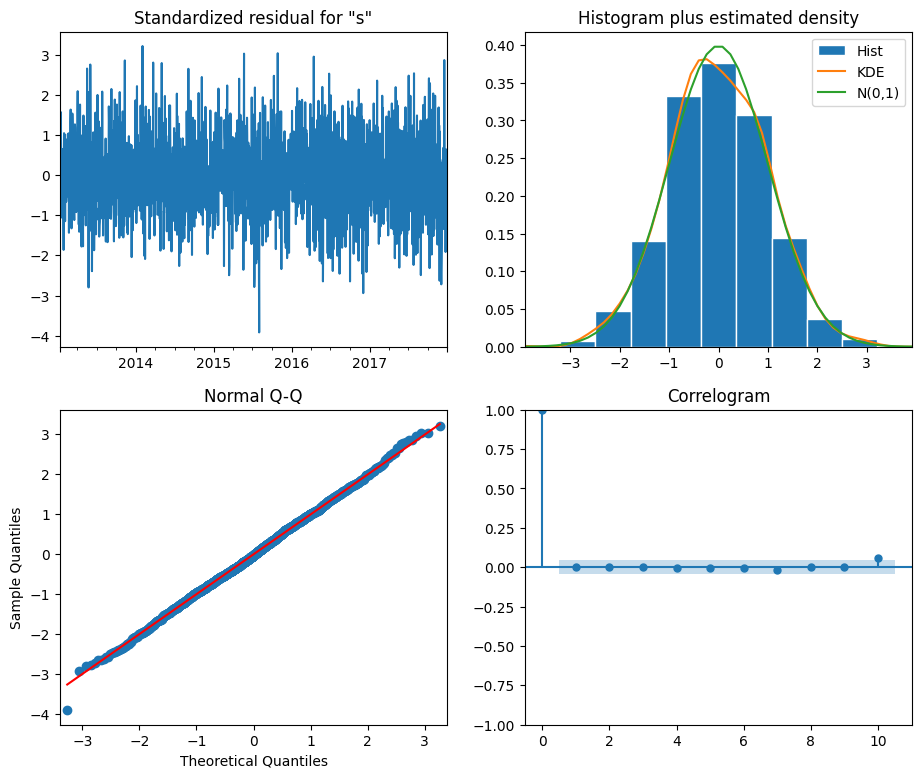

In [60]:
# Create the 4 diagostics plots
sarima_02_results.plot_diagnostics()
plt.show()

* **Standardized residual**: There are no obvious patterns in the residuals. This is our case which points out to a good model

* **Histogram plus kde estimate**: The histogram shows the measured distribution of the residuals while the green line shows the KDE curve (smoothed version of the histogram). The green line shows a normal distribution. For a good model the orange line should be similar to the green line. The orange curve is not very similar to the green one.

* **Correlogram** or ACF plot: 95% of correlations for lag greater than one should not be significant (inside the blue area). This is also the case, i.e., good model

* **Normal Q-Q:** Most of the data points should lie on the straight line, indicating a normal distribution of the residuals. This happens here.

Comparing with previous model, `sarima_01_model`: the kde curve of the previous model is closer to a normal distribution than the kde curve of this model (`sarima_02_model`). In addition, `sarima_01_model` has smaller MAE, 4.55 against 4.788 MAE obtained by `sarima_02_model`.

This would point us to choose `sarima_01_model` as the most promising model.

# Forecasting

## SARIMA vs ARIMA forecasts

We will continue using both ARIMA and SARIMA models even if we know that SARIMA in this case is the most adequate model. The goal here is to show why SARIMA is the most adequate.

### Forecast in Sample

To have a feeling on how good the chosen models are doing we will take the last 90 days in training dataset as validation data.

### Metrics Used to Compare Models

The models presented here and in the [next notebook](https://github.com/MKB-Datalab/time-series-analysis-with-SARIMAX-and-Prophet/blob/master/notebooks/03-Forecasting_with_Facebook_Prophet.ipynb) will be evaluated using [`MAE (Mean Absolute Error)`]( https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error) and [`MAPE (Mean Absolute Percentage Error)`]( https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error). These are popular metrics when evaluating regression models and you will come often across [MAE and MAPE when evaluating forecasting models]( https://otexts.com/fpp2/accuracy.html). 

When comparing forecast methods applied to a single time series, or to several time series with the same units, `MAE` is popular as it is easy to both understand and compute. Percentage errors measures such as `MAPE` have the advantage of being unit-free, and so are frequently used to compare forecast performances between data sets.

In [61]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -5821.102
Date:                Wed, 09 Apr 2025   AIC                          11662.204
Time:                        16:47:27   BIC                          11717.297
Sample:                    01-01-2013   HQIC                         11682.527
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5077      0.022    -23.156      0.000      -0.551      -0.465
ar.L2          0.2374      0.012     19.253      0.000       0.213       0.262
ar.L3         -0.5673      0.012    -47.901      0.000      -0.591      -0.544
ar.L4         -0.9490      0.021    -44.386      0.000      -0.991      -0.907
ma.L1         -0.4131      0.034    -12.024      0.000      -0.480      -0.346
ma.L2         -0.6482      0.044    -14.615      0.000      -0.735      -0.561
ma.L3          0.7652      0.032     23.712      0.000       0.702       0.828
ma.L4          0.3933      0.044      8.992      0.000       0.308       0.479
ma.L5         -0.7916      0.031    -25.243      0.000      -0.853      -0.730
sigma2        33.3244      1.132     29.428      0.000      31.105      35.544
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 8.48
Prob(Q):                              0.45   Prob(JB):                         0.01
Heteroskedasticity (H):               1.33   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
sarima_01_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1826
Model:             SARIMAX(0, 1, 6)x(0, 1, [1], 7)   Log Likelihood               -5734.902
Date:                             Wed, 09 Apr 2025   AIC                          11485.804
Time:                                     16:47:28   BIC                          11529.848
Sample:                                 01-01-2013   HQIC                         11502.054
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8688      0.023    -37.673      0.000      -0.914      -0.824
ma.L2          0.0019      0.032      0.060      0.952      -0.061       0.065
ma.L3         -0.0070      0.033     -0.216      0.829      -0.071       0.057
ma.L4          0.0082      0.030      0.270      0.787      -0.051       0.068
ma.L5         -0.0022      0.030     -0.072      0.942      -0.062       0.057
ma.L6         -0.0064      0.024     -0.268      0.789      -0.054       0.041
ma.S.L7       -0.9915      0.007   -150.225      0.000      -1.004      -0.979
sigma2        31.6282      1.096     28.847      0.000      29.479      33.777
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.15
Prob(Q):                              0.97   Prob(JB):                         0.13
Heteroskedasticity (H):               1.31   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
sarima_02_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 1)x(6, 1, [], 7)   Log Likelihood               -5826.363
Date:                            Wed, 09 Apr 2025   AIC                          11680.726
Time:                                    16:47:28   BIC                          11757.803
Sample:                                01-01-2013   HQIC                         11709.164
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0671      0.026      2.594      0.009       0.016       0.118
ar.L2          0.0575      0.027      2.117      0.034       0.004       0.111
ar.L3          0.0467      0.026      1.799      0.072      -0.004       0.098
ar.L4          0.0486      0.026      1.905      0.057      -0.001       0.099
ar.L5          0.0363      0.026      1.390      0.165      -0.015       0.087
ar.L6          0.0410      0.025      1.613      0.107      -0.009       0.091
ma.L1         -0.9463      0.014    -69.672      0.000      -0.973      -0.920
ar.S.L7       -0.8558      0.024    -36.375      0.000      -0.902      -0.810
ar.S.L14      -0.6815      0.032    -21.632      0.000      -0.743      -0.620
ar.S.L21      -0.5757      0.035    -16.430      0.000      -0.644      -0.507
ar.S.L28      -0.4127      0.033    -12.482      0.000      -0.478      -0.348
ar.S.L35      -0.2412      0.031     -7.798      0.000      -0.302      -0.181
ar.S.L42      -0.1133      0.024     -4.677      0.000      -0.161      -0.066
sigma2        35.3660      1.202     29.416      0.000      33.010      37.722
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.04
Prob(Q):                              1.00   Prob(JB):                         0.98
Heteroskedasticity (H):               1.31   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The three models seem to present no correlation in the residuals. The ARIMA model is the only one that reject the hypothesis of Jarque_Bera (Prob(JB) < 0.05). Therefore, for this model the residuals are NOT normally distributed. 

For our forecasting in sample we use the method `get_prediction` using the last days of the training data as validation data. After that we use `mean_absolute_error` and `mean_absolute_percentage_error` from `sklearn.metrics` to obtain `MAE` and `MAPE` for all three models.

In [64]:
# Create ARIMA mean forecast
arima_pred = arima_results.get_prediction(start=-90, dynamic=True)
arima_mean = arima_pred.predicted_mean

# Create SARIMA mean forecast
sarima_01_pred = sarima_01_results.get_prediction(start=-90, dynamic=True)
sarima_01_mean = sarima_01_pred.predicted_mean

# Create SARIMA mean forecast
sarima_02_pred = sarima_02_results.get_prediction(start=-90, dynamic=True)
sarima_02_mean = sarima_02_pred.predicted_mean

In [65]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

metrics_arima = [round(mean_absolute_error(df_store_2_item_28_time[-90:],arima_mean),3), 
                 round(mean_absolute_percentage_error(df_store_2_item_28_time[-90:],arima_mean),3)]

In [66]:
metrics_sarima_01 = [round(mean_absolute_error(df_store_2_item_28_time[-90:],sarima_01_mean),3), 
                       round(mean_absolute_percentage_error(df_store_2_item_28_time[-90:],sarima_01_mean),3)]

In [67]:
metrics_sarima_02 = [round(mean_absolute_error(df_store_2_item_28_time[-90:],sarima_02_mean),3),
                       round(mean_absolute_percentage_error(df_store_2_item_28_time[-90:],sarima_02_mean),3)]

In [68]:
df_arima_results = pd.DataFrame({'metrics':['MAE','MAPE'],
              'ARIMA(4,1,5)':metrics_arima, 
              'SARIMA(0,1,6)(0,1,1)7':metrics_sarima_01,
              'SARIMA(6,1,1)(6,1,0)7':metrics_sarima_02,
             })

df_arima_results

,metrics,"ARIMA(4,1,5)","SARIMA(0,1,6)(0,1,1)7","SARIMA(6,1,1)(6,1,0)7"
0,MAE,6.911,6.910,6.285
1,MAPE,0.298,0.301,0.213


In [69]:
# save results in csv

df_arima_results.to_csv("../data/processed/results_arima.csv", index=False)

The second SARIMA model, the one pointed out by the automated model selection shows the best values for the metrics considered. 

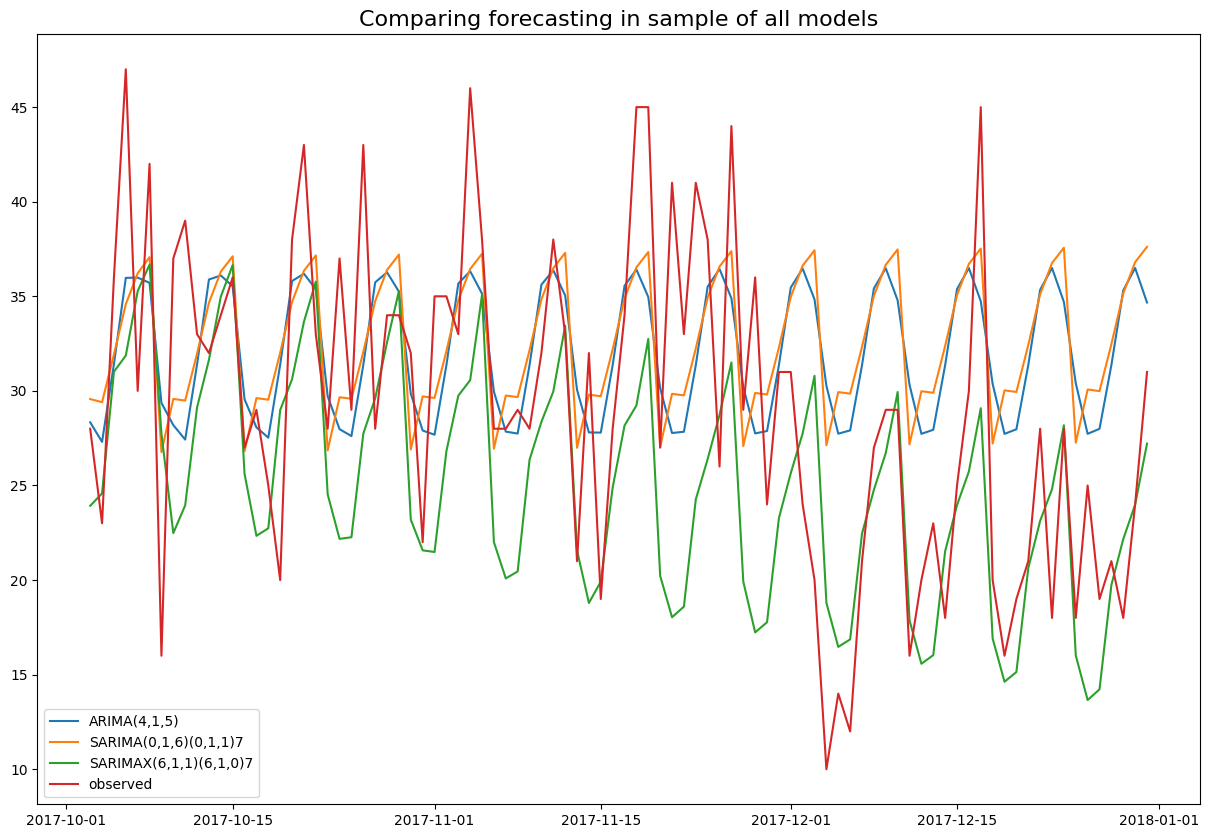

In [70]:
dates = df_store_2_item_28_time.index
# Plot mean ARIMA and SARIMA predictions and observed
plt.figure(figsize=(15,10))
plt.title('Comparing forecasting in sample of all models', size = 16)
plt.plot(arima_mean.index, arima_mean, label='ARIMA(4,1,5)')
plt.plot(sarima_01_mean.index, sarima_01_mean, label='SARIMA(0,1,6)(0,1,1)7')
plt.plot(sarima_02_mean.index, sarima_02_mean, label='SARIMAX(6,1,1)(6,1,0)7')
plt.plot(df_store_2_item_28_time[-90:], label='observed')
plt.legend()
plt.show()

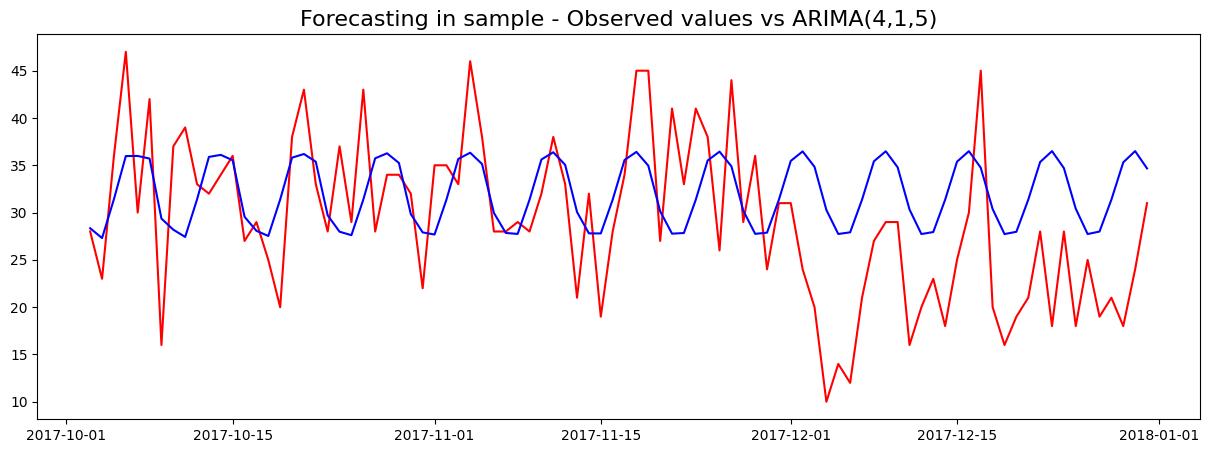

In [71]:
plt.figure(figsize=(15,5))
plt.title('Forecasting in sample - Observed values vs ARIMA(4,1,5)', size = 16)
plt.plot(df_store_2_item_28_time[-90:], label='observed', color='red')
plt.plot(arima_mean.index, arima_mean, label='ARIMA(4,1,5)', color='blue')


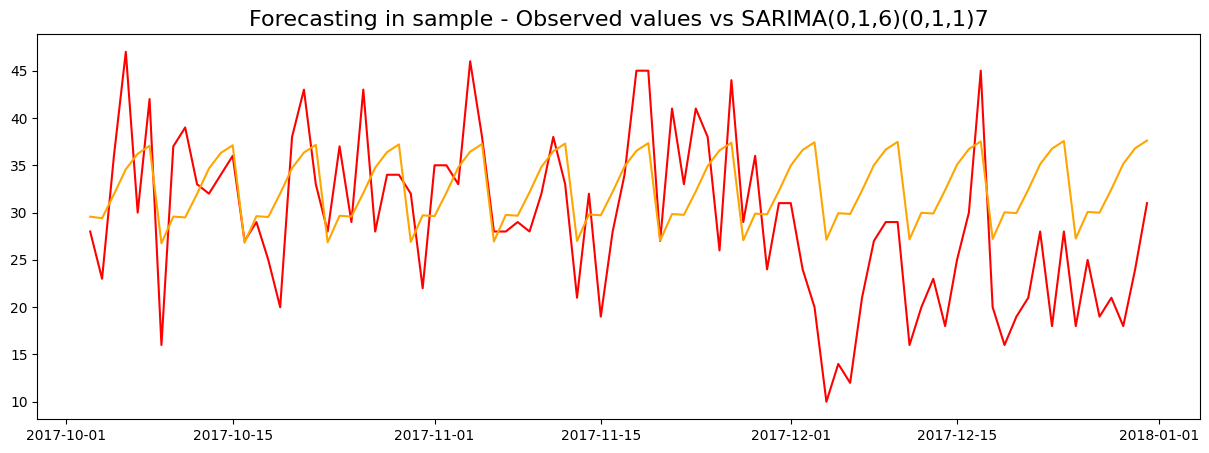

In [72]:
plt.figure(figsize=(15,5))
plt.title('Forecasting in sample - Observed values vs SARIMA(0,1,6)(0,1,1)7', size = 16)
plt.plot(df_store_2_item_28_time[-90:], label='observed', color='red')
plt.plot(sarima_01_mean.index, sarima_01_mean, label='SARIMA(0,1,6)(0,1,1)7', color='orange')


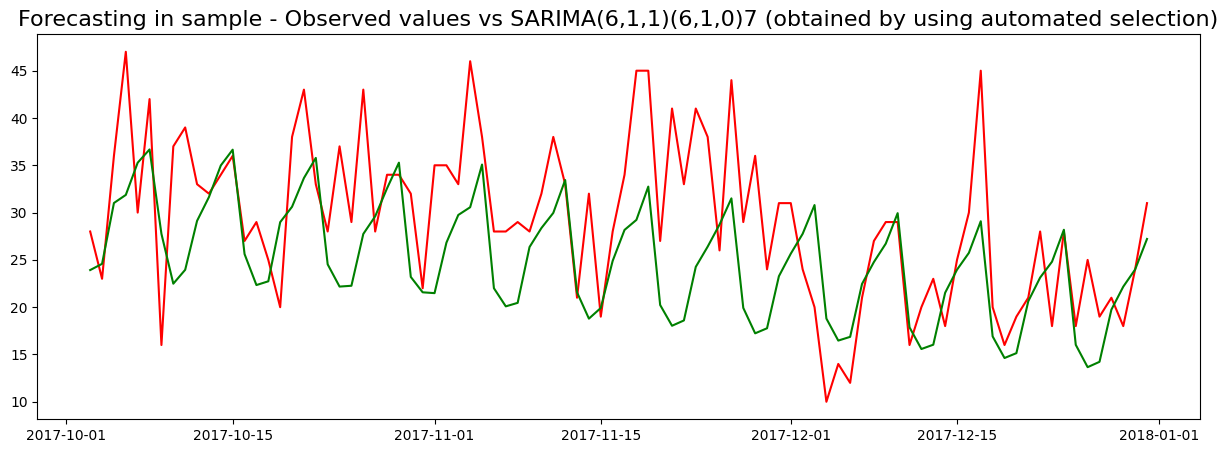

In [73]:
plt.figure(figsize=(15,5))
plt.title('Forecasting in sample - Observed values vs SARIMA(6,1,1)(6,1,0)7 (obtained by using automated selection)', size = 16)
plt.plot(df_store_2_item_28_time[-90:], label='observed', color='red')
plt.plot(sarima_02_mean.index, sarima_02_mean, label='SARIMA(6,1,1)(6,1,0)7', color='green')


Observe how the result of the SARIMA(6,1,1)(6,1,0)7 model (green line) follows better the red curve (observed values) than the ARIMA model (blue line) and the other SARIMA model (SARIMA(0,1,6)(0,1,1)7, orange line).

### Forecast Out of Sample

Let's predict 90 days ahead. For this part we will just use the ARIMA model (ARIMAX(4,1,5)) and the SARIMA model chosen by automated model selection: SARIMA(6,1,1)x(6,1,0)7.

Notice that now we use `get_forecast` in place of `get_predict`.

In [74]:
# Create ARIMA mean forecast
arima_pred = arima_results.get_forecast(steps=90)
arima_mean = arima_pred.predicted_mean

In [75]:
# ARIMA predictions
arima_mean

2018-01-01    19.526488
2018-01-02    19.998060
2018-01-03    18.022591
2018-01-04    22.034728
2018-01-05    26.410531
                ...    
2018-03-27    18.924643
2018-03-28    18.964524
2018-03-29    21.942383
2018-03-30    25.608109
2018-03-31    26.684146
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

In [76]:
# Create SARIMA mean forecast
sarima_02_pred = sarima_02_results.get_forecast(steps=90)
sarima_02_mean = sarima_02_pred.predicted_mean

In [77]:
# SARIMA predictions
sarima_02_mean

2018-01-01    14.429105
2018-01-02    19.895778
2018-01-03    14.987993
2018-01-04    19.779661
2018-01-05    22.843215
                ...    
2018-03-27     0.798031
2018-03-28    -2.070625
2018-03-29     0.890676
2018-03-30     3.790953
2018-03-31     3.114741
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

Notice that we are covering the interval in our test set.

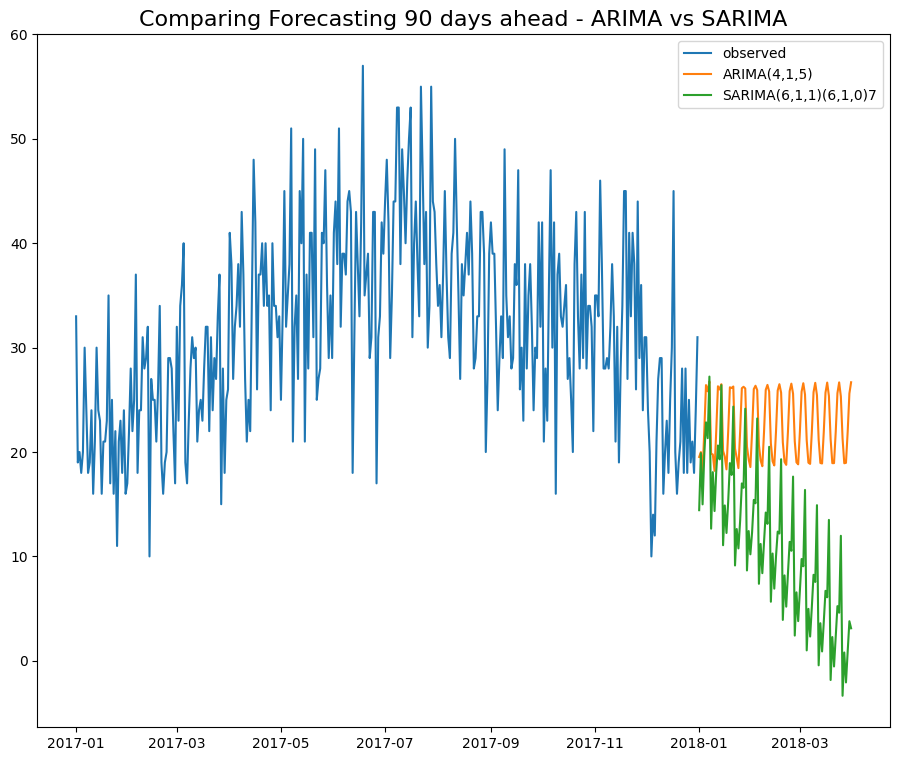

In [78]:
dates = df_store_2_item_28_time.index
# Plot mean ARIMA and SARIMA predictions and observed
plt.title("Comparing Forecasting 90 days ahead - ARIMA vs SARIMA", size =16)
plt.plot(df_store_2_item_28_time['2017':], label='observed')
plt.plot(arima_mean.index, arima_mean, label='ARIMA(4,1,5)')
plt.plot(sarima_02_mean.index, sarima_02_mean, label='SARIMA(6,1,1)(6,1,0)7')
plt.legend()
plt.show()

Again, see how the SARIMA model seems to follow better our time series. Remember, the ARIMA model completely ignores the seasonal information which explains in great deal such difference between these two models.

# Adding exogenous variable

Once the best model is found, it is useful to know how to save it. For this we use the `joblib` library.

In [79]:
df = df_store_2_item_28_time.copy()

In [80]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Create custom calendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start='2013-01-01', end='2017-12-31')

# Convert to datetime if needed
holidays = pd.to_datetime(holidays)


In [81]:
holidays

DatetimeIndex(['2013-01-01', '2013-01-21', '2013-02-18', '2013-05-27',
               '2013-07-04', '2013-09-02', '2013-10-14', '2013-11-11',
               '2013-11-28', '2013-12-25', '2014-01-01', '2014-01-20',
               '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01',
               '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25',
               '2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10',
               '2017-11-23', '2017-12-25'],
              dtype='datetime64[ns]', freq=None)

In [82]:
df['holiday'] = df.index.isin(holidays).astype(int)


In [83]:
df

,sales,holiday
2013-01-01,12,1
2013-01-02,16,0
2013-01-03,16,0
2013-01-04,20,0
2013-01-05,16,0
...,...,...
2017-12-27,19,0
2017-12-28,21,0
2017-12-29,18,0
2017-12-30,24,0


MAE with exogenous variables: 4.787


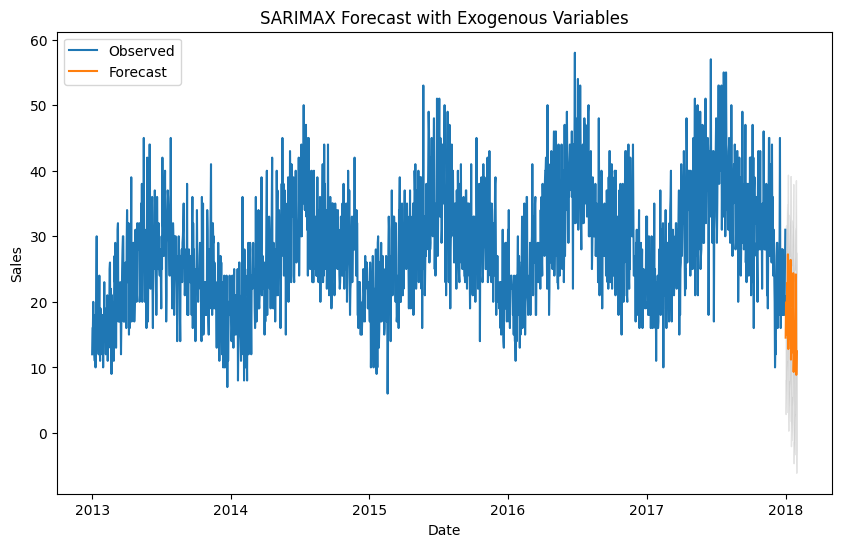

In [84]:
# Example: Adding a 'holiday' indicator
df['holiday'] = df.index.isin(holidays).astype(int)


# Ensure all exogenous variables are aligned and have no missing values
exog_vars = df[['holiday']]

# Step 2: Fit the SARIMAX Model with Exogenous Variables
sarima_exog_model = SARIMAX(df['sales'], order=(6, 1, 1), seasonal_order=(6, 1, 0, 7), exog=exog_vars)
sarima_exog_results = sarima_exog_model.fit()

# Step 3: Evaluate Model Performance
mae_exog = np.mean(np.abs(sarima_exog_results.resid))
print(f'MAE with exogenous variables: {mae_exog:.3f}')

# Step 4: Forecasting with Exogenous Variables
# Define the number of periods to forecast
forecast_steps = 30

# Create a DataFrame for future exogenous variables
# This should be based on your knowledge of future events
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
future_exog = pd.DataFrame({
    'holiday': future_dates.isin(holidays).astype(int)
}, index=future_dates)

# Generate forecasts
forecast = sarima_exog_results.get_forecast(steps=forecast_steps, exog=future_exog)

# Extract predicted mean and confidence intervals
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sales'], label='Observed')
plt.plot(predicted_mean.index, predicted_mean, label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.legend()
plt.show()

# Conclusions

In this section we introduced ARIMA models and its variants: Seasonal ARIMA (SARIMA) and ARIMAX which uses external data (exogenous inputs) to improve the performance of the ARIMA model. 

We followed the Box-Jenkins method to find the best model considering a part of our dataset (time series of sales of product 28 of Walmart's store 2). As first step we've identified important characteristics of our time series such as stationarity and seasonality. 

Then, we also used graphical and statistical methods such as follows to find the best fit model:
* [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test),
* [Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test](https://en.wikipedia.org/wiki/KPSS_test),
* ACF and PACF plots analysis, 
* Exploring model summary statistics,
* Analyze plots obtained using the statsmodel method `plot_diagnostics`.  

Once we've found a model considered good, we used it to forecast in sample, i.e., we applied the model on part of the training data as validation data. Like this, we were able to have a feeling of how good the model is. After that we forecast out of the sample, i.e., 90 days in future. 

